## Machine Learning based Reputation function

- Test reputation/ranking with a StellarGraph framework: 

Approaches tested
 * Node2Vec
 
 
 
## Datasets 
 - Exchange of gossip data 


In [71]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [49]:
G_nx = nx.read_edgelist('datasets/wg_pPeer_1:peer.gel', create_using=nx.DiGraph)
G = StellarGraph.from_networkx(G_nx, edge_weight_attr='total_received')

In [50]:
labels = {}
for g in G_nx.nodes():
    v = G_nx.in_degree(g, weight='total_received') - G_nx.out_degree(g, weight='total_received') 
    labels[g] = v
    

In [42]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [51]:
G.nodes()

Index(['10', '1', '15', '6', '7', '11', '18', '2', '16', '5', '21', '20', '14',
       '24', '3', '19', '23', '12', '9', '4', '17', '13'],
      dtype='object')

In [45]:
subjects

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2485, dtype: object

In [24]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 22, Edges: 47

 Node types:
  default: [22]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [47]
        Weights: range=[1240, 8990], mean=4940.21, std=2234.88
        Features: none


In [31]:
walk_number = 100
walk_length = 5

walker = BiasedRandomWalk(
    G,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)


In [32]:
unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)


In [33]:
batch_size = 50
epochs = 2

In [34]:
generator = Node2VecLinkGenerator(G, batch_size)


In [35]:

emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [36]:
x_inp, x_out = node2vec.in_out_tensors()


In [37]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [38]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [39]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/2
352/352 [==============================] - 0s 815us/step - loss: 0.6410 - binary_accuracy: 0.6311
Epoch 2/2
352/352 [==============================] - 0s 870us/step - loss: 0.5961 - binary_accuracy: 0.6887


In [40]:

x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [52]:
node_gen = Node2VecNodeGenerator(G, batch_size).flow(labels.keys())
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

1/1 [==============================] - 0s 102ms/step


In [54]:
{k:l for k,l in enumerate(np.unique(subjects))}

{0: 'Case_Based',
 1: 'Genetic_Algorithms',
 2: 'Neural_Networks',
 3: 'Probabilistic_Methods',
 4: 'Reinforcement_Learning',
 5: 'Rule_Learning',
 6: 'Theory'}

ValueError: 'c' argument has 2485 elements, which is inconsistent with 'x' and 'y' with size 22.

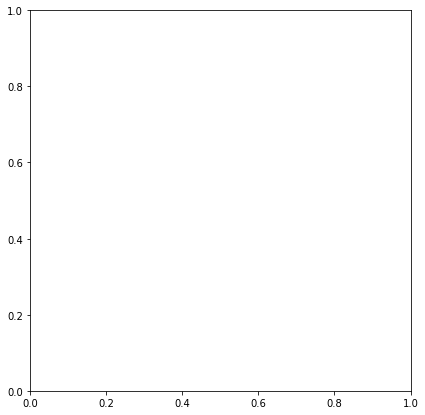

In [53]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [61]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(list(labels.values()))

In [62]:
y

array([ -4340.,   9300.,   6200.,  -8990.,   5580., -13020.,   5890.,
          620., -39370.,   5270.,  -4030.,  -3720.,  -1240.,   9610.,
         6200.,   7130.,   8060.,   1240.,  -3720.,   4030.,   2790.,
         6510.])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (2, 128)
 y_train = (2,)
 X_test = (20, 128)
 y_test = (20,)


In [72]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [73]:
y_pred = clf.predict(X_test)


In [75]:
accuracy_score(y_test, y_pred)

0.05

In [77]:
y_test

array([  7130.,   1240.,   9610.,  -3720., -39370.,   4030.,  -4340.,
         8060.,  -8990.,   9300., -13020.,   2790.,   6200.,   5580.,
        -4030.,  -1240.,   5890.,    620.,  -3720.,   5270.])

In [76]:
y_pred

array([6200., 6510., 6200., 6200., 6510., 6510., 6200., 6200., 6200.,
       6200., 6510., 6200., 6200., 6200., 6510., 6200., 6200., 6200.,
       6510., 6510.])